<a href="https://colab.research.google.com/github/Er-Devjyoti/CIFER_100-Dataset-Analyzing-Best-Transfer-Learning-Approach/blob/main/Thesis_Code_DM996.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DM996- Thesis*

Author: Devjyoti Das


Dataset: 
The CIFAR 100 challenge (https://www.cs.toronto.edu/~kriz/cifar.html) is a widely used benchmark for image classification tasks, and it involves classifying RGB images into 100 different classes. The dataset consists of 50,000 training images and 10,000 test images, and each class has 500 training images and 100 test images.


#Getting data

In this section we load the needed libraries to work on this project and we also upload the CIFAR100 dataset

In [ ]:
import tensorflow as tf, numpy as np, plotly.express as px, plotly.graph_objects as go, pandas as pd
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet169
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
#Set random paramenters
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.cifar100.load_data(label_mode='fine') 
#We can see the sizes of each slice (rows and columns)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


Check the classes

In [ ]:
#We explore the raw content from the source
#We just got numbers instead of names from class column
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
#We found names of the classes For learning and visual reason
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [ ]:
#We need to check if the dataset is balanced
#We created a line graph showing how many elements per class
#We have 2 groups (2 lines each) for train and test dataset
classtrain, counttrain = np.unique(y_train, return_counts=True)
classtest, counttest = np.unique(y_test, return_counts=True)
df_all = pd.concat([pd.DataFrame({'class': classtest, 'count': counttest, 'type': 'test'}), pd.DataFrame({'class': classtrain, 'count': counttrain, 'type': 'train'})])
fig_bar_Graphic = px.line(df_all, x = 'class',y = 'count',color= 'type')
fig_bar_Graphic.update_traces(line=dict(width=8))
fig_bar_Graphic.update_layout(
    title = "Graph: Count class",
    xaxis = dict(title='Type of class'),
    yaxis = dict(title='Number of samples'),
    font=dict(
        size=26
    )
)
fig_bar_Graphic.show()

#TPU or GPU detection

In order to improve the performance and manage oor computational powe, we will ise distribution srategy. It will depend on the hardware available, you'll use different distribution strategies.

- If the TPU is available, then you'll be using the TPU Strategy.
Otherwise:
- If more than one GPU is available, then you'll use the Mirrored Strategy
- If one GPU is available or if just the CPU is available, you'll use the default strategy.

In [ ]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")  
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


#**Visualization Utilities**

In [ ]:
#Let's create a function to see some pictures from the dataset
from matplotlib import pyplot as plt
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display
def display_images(digits, predictions, names, title):
  n = 10
  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  #n_labels = labels[indexes]
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    plt.xlabel(names[n_predictions[i]])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])
#Let's create a function to plot the evolution of accuracy and loss throughout epochs
def display_history_epochs(hist):
  data= []
  data.append(go.Scatter(name="loss", x=hist.epoch, y=hist.history['loss'],line=dict(color="blue",width=3)))
  data.append(go.Scatter(name="accuracy", x=hist.epoch, y=hist.history['accuracy'],line=dict(color="red",width=3)))
  fig0 = go.Figure(data=data)
  fig0.update_layout(
      title = "loss v accuracy",
      xaxis = dict(title='epoch'),
      yaxis = dict(title='values'),
      font=dict(
        size=26
      )
  )
  fig0.show()

Visualise some images

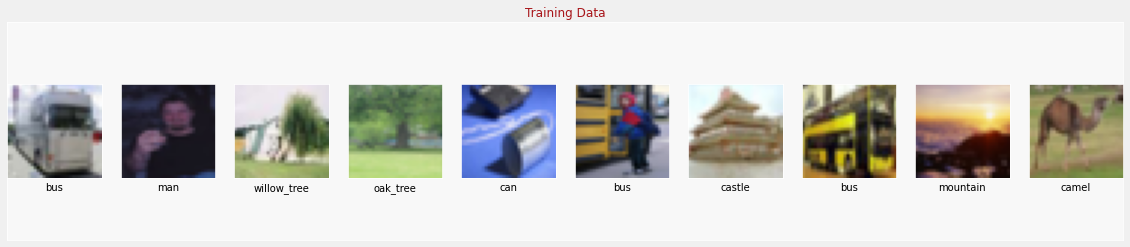

In [ ]:
display_images(x_train, y_train, labels, "Training Data" )

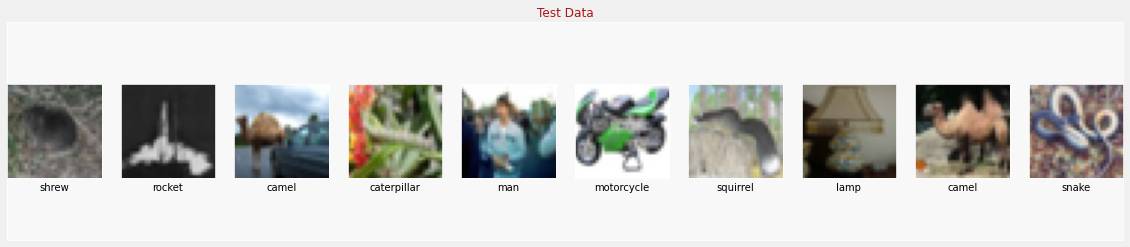

In [ ]:
display_images(x_test, y_test, labels, "Test Data" )

#Build the model

In [ ]:
def freeze_my_model(input_shape, n_classes):
  base_model = EfficientNetB0(input_shape=input_shape,
                                    weights="imagenet",
                                    include_top=False,
                                    classes=n_classes)
  # freeze the layers
  for layer in base_model.layers:
      layer.trainable = False
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.4))
  #model.add(Dense(64, activation='relu')) # new
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model
# Build model with EfficientNetB0 and frost weights
model0 = freeze_my_model(input_shape=(32, 32, 3), n_classes=len(labels))
model0.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
Total params: 4,177,671
Trainable params: 128,100
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
def build_my_model(input_shape, n_classes):
  base_model = EfficientNetB0(input_shape=input_shape,
                                    weights="imagenet",
                                    include_top=False,
                                    classes=n_classes)
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  #model.add(Dense(64, activation='relu')) # new
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
# Build model with EfficientNetB0 and fine tuning
model1 = build_my_model(input_shape=(32, 32, 3), n_classes=len(labels))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               128100    
                                                                 
Total params: 4,177,671
Trainable params: 4,135,648
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
def build_EffV2_model(input_shape, n_classes):
  base2 = EfficientNetV2L(input_shape=input_shape,
                                    weights="imagenet",
                                    include_top=False,
                                    classes=n_classes)
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  model = Sequential()
  model.add(base2)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
# Build model with EfficientNetV2L and fine tuning
model2 = build_EffV2_model(input_shape=(32, 32, 3), n_classes=len(labels))
model2.summary()

473176280/473176280 [==============================] - 13s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, 1, 1, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               128100    
                                                                 
Total params: 117,874,948
Trainable params: 117,362,372
Non-trainable params: 512,576
________________________________

In [ ]:
def build_IncV3_model(input_shape, n_classes):
  base3 = InceptionV3(input_shape=input_shape,
                                    weights="imagenet",
                                    include_top=False,
                                    classes=n_classes)
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  model = Sequential()
  model.add(base3)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
# Build model with InceptionV3 and fine tuning
# We need to reshape the images
model3 = build_IncV3_model(input_shape=(75, 75, 3), n_classes=len(labels))
model3.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 100)               204900    
                                                                 
Total params: 22,007,684
Trainable params: 21,973,252
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
def build_IncV4_model(input_shape, n_classes):
  base4 = InceptionResNetV2(input_shape=input_shape,
                                    weights="imagenet",
                                    include_top=False,
                                    classes=n_classes)
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  model = Sequential()
  model.add(base4)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
# Build model with InceptionResNetV2 and fine tuning
# We need to reshape the images
model4 = build_IncV4_model(input_shape=(75, 75, 3), n_classes=len(labels))
model4.summary()

219055592/219055592 [==============================] - 10s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 100)               153700    
                                                                 
Total params: 54,490,436
Trainable params: 54,429,892
Non-trainable params: 60,544
_____________________________________

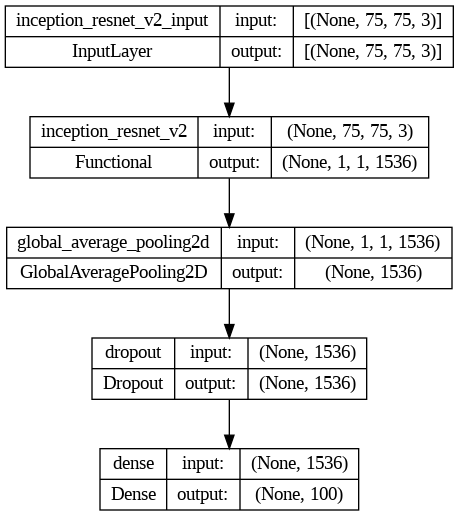

In [ ]:
tf.keras.utils.plot_model(model4, "MODEL4.png", show_shapes=True)

In [ ]:
def build_densenet_model(input_shape, n_classes):
  base5 = DenseNet169(input_shape=input_shape,
                                    weights="imagenet",
                                    include_top=False,
                                    classes=n_classes)
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  model = Sequential()
  model.add(base5)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
# Build model with DenseNet169 and fine tuning
model5 = build_densenet_model(input_shape=(32, 32, 3), n_classes=len(labels))
model5.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 100)               166500    
                                                                 
Total params: 12,809,380
Trainable params: 12,650,980
Non-trainable params: 158,400
_________________________________________________________________


We scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the training set and the testing set are preprocessed in the same way:

We also use data augmentation to create more data to train

In [ ]:
# Generate augmented images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)
test_datagen = ImageDataGenerator(
    # Your Code Here
    rescale=1.0/255.0)
# Convert labels to one hot encoding matrix
print(y_train.shape, y_test.shape)
train_y = to_categorical(y_train, 100)
test_y = to_categorical(y_test, 100)
print(train_y.shape, test_y.shape)

(50000, 1) (10000, 1)
(50000, 100) (10000, 100)


#Training models

In [ ]:
# EfficientNetB0 and frost weights
history0 = model0.fit(train_datagen.flow(x_train,train_y,batch_size=128),
                              steps_per_epoch=50000 / 128,use_multiprocessing = True,epochs=70)

Epoch 1/70
390/390 [==============================] - 52s 99ms/step - loss: 4.6968 - accuracy: 0.0100
Epoch 2/70
390/390 [==============================] - 40s 101ms/step - loss: 4.6878 - accuracy: 0.0101
Epoch 3/70
390/390 [==============================] - 40s 103ms/step - loss: 4.6810 - accuracy: 0.0105
Epoch 4/70
390/390 [==============================] - 39s 100ms/step - loss: 4.6801 - accuracy: 0.0106
Epoch 5/70
390/390 [==============================] - 40s 102ms/step - loss: 4.6782 - accuracy: 0.0099
Epoch 6/70
390/390 [==============================] - 40s 101ms/step - loss: 4.6779 - accuracy: 0.0095
Epoch 7/70
390/390 [==============================] - 39s 100ms/step - loss: 4.6778 - accuracy: 0.0106
Epoch 8/70
390/390 [==============================] - 39s 100ms/step - loss: 4.6754 - accuracy: 0.0105
Epoch 9/70
390/390 [==============================] - 40s 101ms/step - loss: 4.6791 - accuracy: 0.0095
Epoch 10/70
390/390 [==============================] - 40s 102ms/step - lo

In [ ]:
# EfficientNetB0 and Fine tunning
history1 = model1.fit(train_datagen.flow(x_train,train_y,batch_size=128),
                              steps_per_epoch=50000 / 128,use_multiprocessing = True,epochs=30)

Epoch 1/30
390/390 [==============================] - 46s 118ms/step - loss: 1.4534 - accuracy: 0.5887
Epoch 2/30
390/390 [==============================] - 45s 116ms/step - loss: 1.4441 - accuracy: 0.5881
Epoch 3/30
390/390 [==============================] - 47s 119ms/step - loss: 1.4287 - accuracy: 0.5944
Epoch 4/30
390/390 [==============================] - 47s 120ms/step - loss: 1.4115 - accuracy: 0.5955
Epoch 5/30
390/390 [==============================] - 48s 123ms/step - loss: 1.3995 - accuracy: 0.5986
Epoch 6/30
390/390 [==============================] - 46s 117ms/step - loss: 1.3928 - accuracy: 0.6036
Epoch 7/30
390/390 [==============================] - 47s 120ms/step - loss: 1.3757 - accuracy: 0.6069
Epoch 8/30
390/390 [==============================] - 47s 120ms/step - loss: 1.3649 - accuracy: 0.6063
Epoch 9/30
390/390 [==============================] - 46s 116ms/step - loss: 1.3537 - accuracy: 0.6095
Epoch 10/30
390/390 [==============================] - 48s 121ms/step - l

In [ ]:
#EfficientNetV2L and fine tuning
history2 = model2.fit(train_datagen.flow(x_train,train_y,batch_size=128),
                              steps_per_epoch=50000 / 128,use_multiprocessing = True,epochs=25)

Epoch 1/25
390/390 [==============================] - 298s 269ms/step - loss: 4.2954 - accuracy: 0.0532
Epoch 2/25
390/390 [==============================] - 106s 270ms/step - loss: 3.7613 - accuracy: 0.1233
Epoch 3/25
390/390 [==============================] - 105s 267ms/step - loss: 3.4764 - accuracy: 0.1704
Epoch 4/25
390/390 [==============================] - 106s 269ms/step - loss: 3.2676 - accuracy: 0.2063
Epoch 5/25
390/390 [==============================] - 105s 268ms/step - loss: 3.0951 - accuracy: 0.2342
Epoch 6/25
390/390 [==============================] - 105s 265ms/step - loss: 3.0002 - accuracy: 0.2552
Epoch 7/25
390/390 [==============================] - 105s 268ms/step - loss: 2.8625 - accuracy: 0.2810
Epoch 8/25
390/390 [==============================] - 104s 264ms/step - loss: 2.7525 - accuracy: 0.3009
Epoch 9/25
390/390 [==============================] - 108s 275ms/step - loss: 2.6887 - accuracy: 0.3154
Epoch 10/25
390/390 [==============================] - 111s 283m

In [ ]:
resize_image = tf.image.resize(x_train, [75, 75])
print("Resized to", resize_image.shape)
#InceptionV3 and fine tuning (resized image)
history3 = model3.fit(train_datagen.flow(resize_image,train_y,batch_size=128),
                              steps_per_epoch=50000 / 128,use_multiprocessing = True,epochs=25)

Resized to (50000, 75, 75, 3)
Epoch 1/25
390/390 [==============================] - 180s 344ms/step - loss: 3.9704 - accuracy: 0.1206
Epoch 2/25
390/390 [==============================] - 133s 340ms/step - loss: 2.6020 - accuracy: 0.3432
Epoch 3/25
390/390 [==============================] - 143s 364ms/step - loss: 2.1523 - accuracy: 0.4336
Epoch 4/25
390/390 [==============================] - 150s 384ms/step - loss: 1.9223 - accuracy: 0.4841
Epoch 5/25
390/390 [==============================] - 148s 378ms/step - loss: 1.7623 - accuracy: 0.5211
Epoch 6/25
390/390 [==============================] - 145s 370ms/step - loss: 1.6442 - accuracy: 0.5510
Epoch 7/25
390/390 [==============================] - 138s 353ms/step - loss: 1.5504 - accuracy: 0.5722
Epoch 8/25
390/390 [==============================] - 143s 364ms/step - loss: 1.4715 - accuracy: 0.5927
Epoch 9/25
390/390 [==============================] - 139s 354ms/step - loss: 1.4046 - accuracy: 0.6070
Epoch 10/25
390/390 [=============

In [ ]:
#InceptionResNetV2 and fine tuning (resized image)
history4 = model4.fit(train_datagen.flow(tf.image.resize(x_train, [75, 75]),train_y,batch_size=128),
                              steps_per_epoch=50000/128,use_multiprocessing=True,epochs=25)

Epoch 1/25
390/390 [==============================] - 253s 376ms/step - loss: 3.6804 - accuracy: 0.1737
Epoch 2/25
390/390 [==============================] - 153s 390ms/step - loss: 2.3046 - accuracy: 0.3997
Epoch 3/25
390/390 [==============================] - 160s 409ms/step - loss: 1.8877 - accuracy: 0.4888
Epoch 4/25
390/390 [==============================] - 154s 394ms/step - loss: 1.6623 - accuracy: 0.5401
Epoch 5/25
390/390 [==============================] - 162s 411ms/step - loss: 1.5013 - accuracy: 0.5808
Epoch 6/25
390/390 [==============================] - 169s 432ms/step - loss: 1.3813 - accuracy: 0.6110
Epoch 7/25
390/390 [==============================] - 162s 415ms/step - loss: 1.2575 - accuracy: 0.6418
Epoch 8/25
390/390 [==============================] - 152s 387ms/step - loss: 1.1621 - accuracy: 0.6640
Epoch 9/25
390/390 [==============================] - 152s 389ms/step - loss: 1.0815 - accuracy: 0.6869
Epoch 10/25
390/390 [==============================] - 159s 405m

In [ ]:
#DenseNet169 and fine tuning
history5 = model5.fit(train_datagen.flow(x_train,train_y,batch_size=128),
                      steps_per_epoch=50000 / 128,use_multiprocessing = True,epochs=25)

Epoch 1/25
390/390 [==============================] - 209s 225ms/step - loss: 4.1362 - accuracy: 0.1112
Epoch 2/25
390/390 [==============================] - 73s 186ms/step - loss: 2.9835 - accuracy: 0.2784
Epoch 3/25
390/390 [==============================] - 76s 193ms/step - loss: 2.5526 - accuracy: 0.3577
Epoch 4/25
390/390 [==============================] - 73s 185ms/step - loss: 2.3118 - accuracy: 0.4021
Epoch 5/25
390/390 [==============================] - 71s 181ms/step - loss: 2.1552 - accuracy: 0.4331
Epoch 6/25
390/390 [==============================] - 71s 181ms/step - loss: 2.0322 - accuracy: 0.4596
Epoch 7/25
390/390 [==============================] - 71s 181ms/step - loss: 1.9328 - accuracy: 0.4830
Epoch 8/25
390/390 [==============================] - 70s 179ms/step - loss: 1.8428 - accuracy: 0.5039
Epoch 9/25
390/390 [==============================] - 71s 179ms/step - loss: 1.7701 - accuracy: 0.5193
Epoch 10/25
390/390 [==============================] - 70s 178ms/step - 

In [ ]:
#Plot InceptionResNetV2
display_history_epochs(history4)

#Evaluate the model

In [ ]:
model0.evaluate(test_datagen.flow(x_test,test_y), verbose=0)

[4.639364242553711, 0.009999999776482582]

In [ ]:
model1.evaluate(test_datagen.flow(x_test,test_y), verbose=0)

[5.457980632781982, 0.17839999496936798]

In [ ]:
model2.evaluate(test_datagen.flow(x_test,test_y), verbose=0)

[1.817291021347046, 0.5130000114440918]

In [ ]:
#Let resize the test dataset tf.image.resize(x_test, [75, 75])
model3.evaluate(test_datagen.flow(tf.image.resize(x_test, [75, 75]),test_y), verbose=0)

[1.2412291765213013, 0.6699000000953674]

In [ ]:
#Let resize the test dataset tf.image.resize(x_test, [75, 75]) with 25 epochs
model4.evaluate(test_datagen.flow(tf.image.resize(x_test, [75, 75]),test_y), verbose=0)

[1.328855276107788, 0.7103000283241272]

In [ ]:
#Let resize the test dataset tf.image.resize(x_test, [75, 75]) with 30 epochs
model4.evaluate(test_datagen.flow(tf.image.resize(x_test, [75, 75]),test_y), verbose=0)

[1.4856456518173218, 0.7077999711036682]

In [ ]:
model5.evaluate(test_datagen.flow(x_test,test_y), verbose=0)

[1.6846433877944946, 0.5715000033378601]

In [ ]:
probabilities = model4.predict(tf.image.resize(x_test, [75, 75]), batch_size=128, use_multiprocessing=True)
probabilities = np.argmax(probabilities, axis = 1)

display_images(x_test, probabilities, labels, "Review test")

NameError: ignored

#Save the model

In [ ]:
#Save the best model
#model4.save_weights("cifar100_incv4_weights.h5")
!mkdir -p saved_model
model4.save('saved_model/my_model')

In [ ]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 79%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 93%)
  adding: content/saved_model/my_model/assets/ (stored 0%)
  adding: content/saved_model/my_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/my_model/keras_metadata.pb (deflated 96%)


In [ ]:
import tensorflow as tf
#Load the best model from saved
new_model = tf.keras.models.load_model('saved_model/my_model')
# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 100)               153700    
                                                                 
Total params: 54,490,436
Trainable params: 54,429,892
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
new_model.evaluate(test_datagen.flow(tf.image.resize(x_test, [75, 75]),test_y), verbose=0, use_multiprocessing=True, steps=128)

[1.372917890548706, 0.707275390625]